<a href="https://colab.research.google.com/github/TerryTian21/PyTorch-Practice/blob/main/Tutorials/Feauture_Scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Scaling

A quick exploration of how feature scaling affects the performance of different models. In theory, distance based algorithms should experience the greatest improvement while tree based algorithms are unaffected.
- KNN
- SVG ( Support Vector Regression)
- Decision Trees

In [91]:
# Import Libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

Targets is median house value

In [92]:
# Import dataset

from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
df = pd.DataFrame(data=data.data, columns=data.feature_names)
df["targets"] = data.target
df.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,targets
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [93]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,targets
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [94]:
df.isna().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
targets       0
dtype: int64

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   targets     20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [96]:
# Proof of Concept Instantiate Values

knn = KNeighborsRegressor()
svr = SVR()
tree = DecisionTreeRegressor()

# List of scalers
norm = MinMaxScaler()
standard = StandardScaler()
robust = RobustScaler()
scalers = [norm, standard, robust]


Slight Digression - Preparing some feature crosses

In [97]:
lat_min = df["Latitude"].min()
lat_max = df["Latitude"].max()
long_min = df['Longitude'].min()
long_max = df['Longitude'].max()

lat_min, lat_max, long_min, long_max


(32.54, 41.95, -124.35, -114.31)

In [98]:
lat_bins = np.arange(lat_min, lat_max, 1)
long_bins = np.arange(long_min, long_max, 1)

In [99]:
df['binned_latitude'] = pd.cut(df['Latitude'], bins=lat_bins)
df['binned_longitude'] = pd.cut(df["Longitude"], bins=long_bins)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MedInc            20640 non-null  float64 
 1   HouseAge          20640 non-null  float64 
 2   AveRooms          20640 non-null  float64 
 3   AveBedrms         20640 non-null  float64 
 4   Population        20640 non-null  float64 
 5   AveOccup          20640 non-null  float64 
 6   Latitude          20640 non-null  float64 
 7   Longitude         20640 non-null  float64 
 8   targets           20640 non-null  float64 
 9   binned_latitude   20602 non-null  category
 10  binned_longitude  20638 non-null  category
dtypes: category(2), float64(9)
memory usage: 1.5 MB


Original Approach

1. Create an embeddings for each example in the dataset
2. Embed the inputs
3. Concatenate the two embeddings and flatten
4. There is your numeric embedding for categorical variable

In [101]:
feature_cross = df['binned_latitude'].astype(str) + df['binned_longitude'].astype(str)
df['feature_cross'] = feature_cross
df['feature_cross'].head(5)

0    (37.54, 38.54](-122.35, -121.35]
1    (37.54, 38.54](-122.35, -121.35]
2    (37.54, 38.54](-122.35, -121.35]
3    (37.54, 38.54](-122.35, -121.35]
4    (37.54, 38.54](-122.35, -121.35]
Name: feature_cross, dtype: object

Let's create our training and test data by using a subset of the features
- Medain Income
- House Age
- Populateion
- Average Rooms

In [102]:
from sklearn.model_selection import train_test_split

columns = ['MedInc', 'HouseAge', 'AveRooms', 'Population']
X = df[columns]
y = df['targets']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

## KNN

In [157]:
knn_rmse = []

knn.fit(X_train, y_train)
y_preds = knn.predict(X_test)
knn_rmse.append(np.sqrt(mean_squared_error(y_test, y_preds)))

knn_rmse

[1.053907126837436]

In [158]:
# Try scaling techniques (theoretically should get better results)

prediction_results = []

prediction_results.append(y_preds)

for scaler in scalers:
  pipe = make_pipeline(scaler, knn)
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)
  prediction_results.append(y_pred)
  knn_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

knn_rmse

[1.053907126837436, 0.8105593293559593, 0.7931378470148402, 0.7990507043639139]

As expected scaling the features improves model performance

In [159]:
knn_df = pd.DataFrame(data=knn_rmse, columns=["RMSE"], index=["No Scaling", "MinMax", "Standard", "Robust"])
knn_df

,RMSE
No Scaling,1.053907
MinMax,0.810559
Standard,0.793138
Robust,0.799051


In [160]:
print(len(prediction_results[0]))

print("First Feature")
feature = X_test.values[:, 0]
print(f"Shape: {feature.shape}")
print(f"Value: {feature[0]}")

print(f"Shape of y_test {y_test.shape}")


4128
First Feature
Shape: (4128,)
Value: 1.6812
Shape of y_test (4128,)


In [187]:
print(y_test.values[1])


0.458


We Will ploat a 4x4 scatter plot showing how each affects prediction outcomes and for each of the different scaling methods.

In [188]:
# We can visualize the predictions using a scatter plot.
import random

def plot_results(predictions: list):
  """ Plots a scatter plot showing how each of the features impacts the target for a given feature scaling method
  """

  fig, ax = plt.subplots(4,4)
  fig.set_figwidth(30)
  fig.set_figheight(30)

  columns = ['MedInc', 'HouseAge', 'AveRooms', 'Population']
  scaling_type = ["No Scaling", "MinMax", "Standard", "Robust"]

  indices = np.random.choice(len(X_test), 15)

  for index, scaler in enumerate(predictions):
    for i in range(4):

      feature = X_test.values[:, i]

      # tuples = zip(feature, scaler, y_test)
      # random_sample = random.sample(list(tuples), 15)

      plot_feature = [feature[x] for x in indices]
      plot_predict = [scaler[x] for x in indices]
      plot_true = [y_test.values[x] for x in indices]

      ax[index, i].set_xlabel(scaling_type[i])
      ax[index, i].set_ylabel("Median House Value")
      ax[index, i].set_title(f"{scaling_type[index]} with {columns[i]} feature")
      ax[index, i].scatter(plot_feature, plot_predict, c="b", marker="o", label="Predicts")
      ax[index, i].scatter(plot_feature, plot_true, c="g", marker="x", label="True")
      ax[index, i].legend()

      # Connect the dots
      for item in range(len(plot_feature)):
        ax[index, i].plot([plot_feature[item], plot_feature[item]], [plot_true[item], plot_predict[item]], color='gray', linestyle='--')



In [156]:
print(len(prediction_results))

3


[1509 3430  570 2630 4060   54  770  804 3247 4000 3737 3918 1581 3723
 3660]


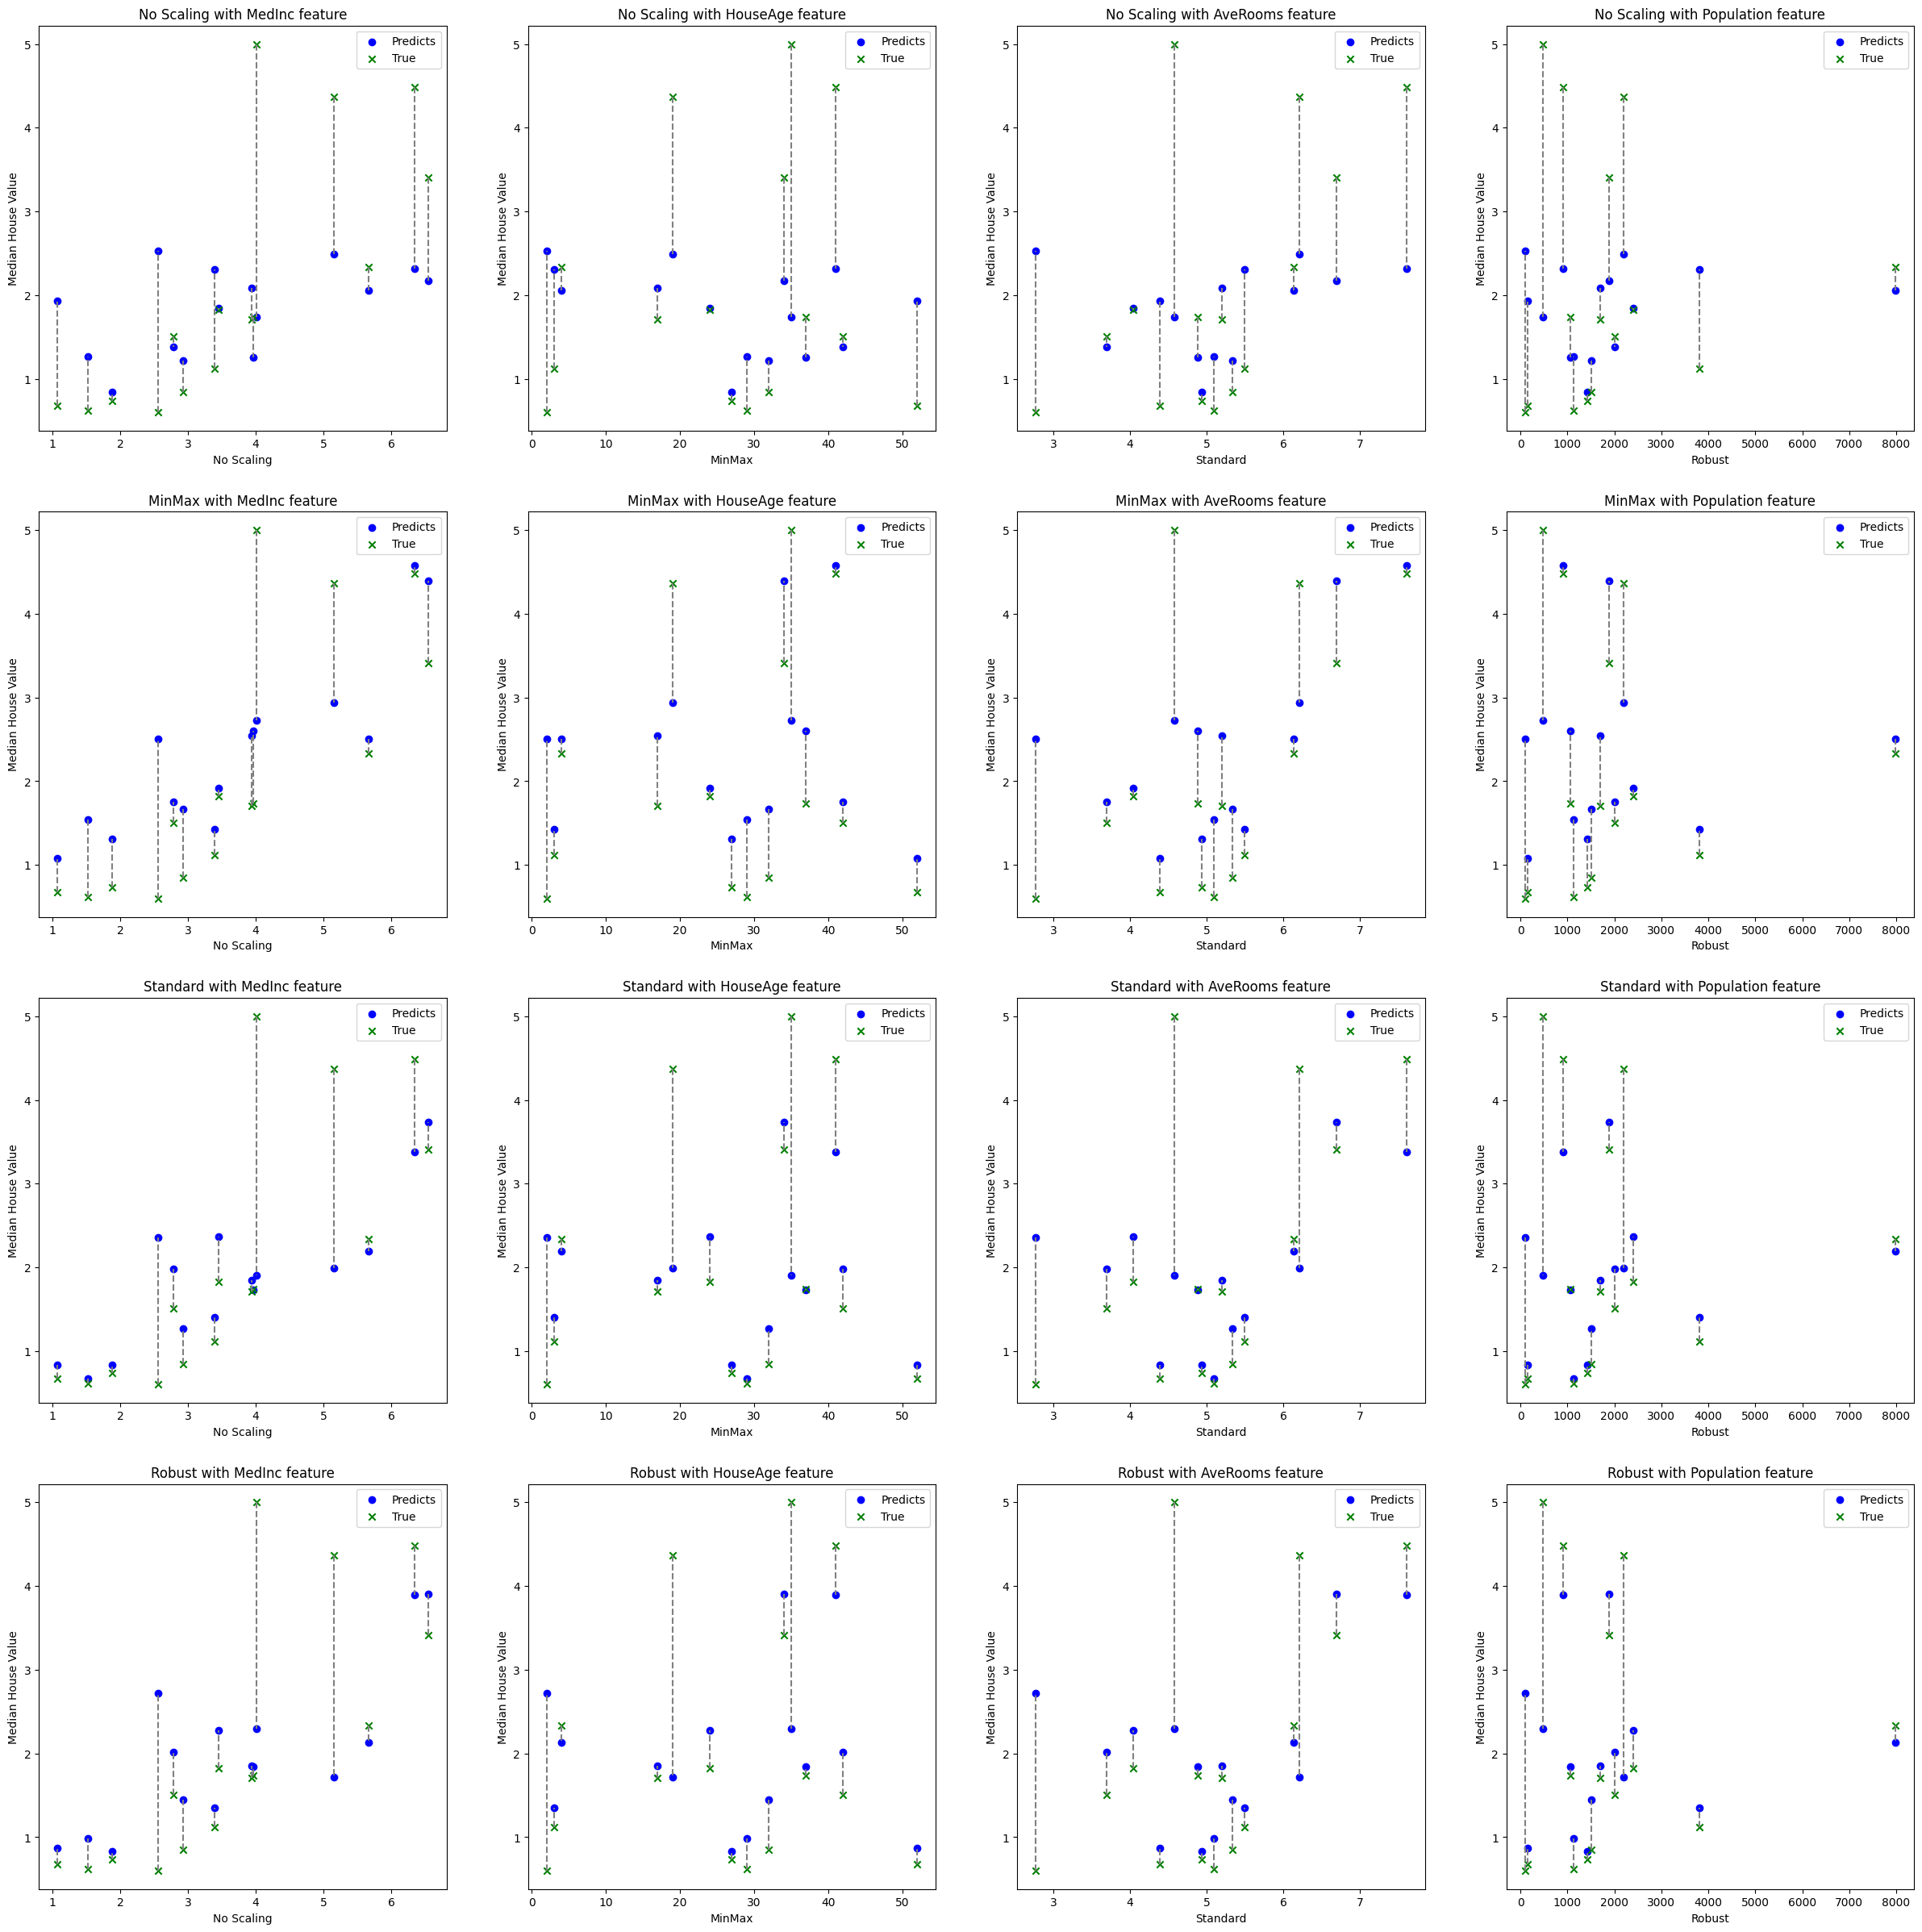

In [189]:
plot_results(prediction_results)

## SVG


## Decision Trees